# Prototype for the processing of NRT MSWEP 280

In [1]:
import pathlib

In [2]:
%matplotlib inline
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

In [3]:
from datetime import datetime, timedelta

from dateutil.relativedelta import relativedelta

In [4]:
import numpy as np
import pandas as pd
import xarray as xr

In [5]:
from dask.diagnostics import ProgressBar

In [6]:
from ICU_Water_Watch import MSWEP, domains, geo, plot, utils

In [7]:
dpath = "/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge"
dpath_shapes = "/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/"
domain_name = "SP"
nbdays_agg = 60
lag_to_realtime = 1
varname = "precipitation"
fig_kwargs = dict(dpi=200, bbox_inches="tight", facecolor="w")
clim_start = 1991
clim_stop = 2020

In [8]:
# %%
dpath = pathlib.Path(dpath).joinpath(domain_name)
dpath_shapes = pathlib.Path(dpath_shapes)
dpath_climatology = dpath.joinpath(
    f"climatologies/{nbdays_agg}days/{clim_start}_{clim_stop}/netcdf"
)
opath = dpath.joinpath("outputs")

opath.mkdir(parents=True, exist_ok=True)

# %% get the EEZs shapefiles, individual + merged
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes=dpath_shapes)

# %%
today = datetime.utcnow().date()
date_stop = today - timedelta(days=lag_to_realtime)
DOY_stop = date_stop.timetuple().tm_yday
date_start = date_stop - timedelta(days=nbdays_agg - 1)
DOY_start = date_start.timetuple().tm_yday


# %%
lfiles = list(dpath.glob("MSWEP_Daily_????-??-??.nc"))
lfiles.sort()
lfiles = lfiles[-nbdays_agg:]

In [9]:
# %% get the bounding dates, from the list of files, and test

date_first_file = datetime.strptime(lfiles[0].name[-13:-3], "%Y-%m-%d").date()
date_last_file = datetime.strptime(lfiles[-1].name[-13:-3], "%Y-%m-%d").date()

In [10]:
# %%
date_last_file == date_stop

False

In [11]:
# %%
date_first_file == date_start

False

In [12]:
dset = MSWEP.make_dataset(lfiles)

In [13]:
dset

<xarray.Dataset>
Dimensions:        (time: 60, lat: 800, lon: 1400)
Coordinates:
  * lon            (lon) float32 100.1 100.2 100.3 100.4 ... 239.8 239.9 240.0
  * lat            (lat) float32 -49.95 -49.85 -49.75 ... 29.75 29.85 29.95
  * time           (time) datetime64[ns] 2023-03-04 2023-03-05 ... 2023-05-02
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 800, 1400), meta=np.ndarray>
    DOY            (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    history:          Created on 2023-03-05 01:02
    input_data_hash:  8ab2da0395b0d92c9629341f6ff44b00769d023bae70fe684dfb22b...
    filename_origin:  2023063.nc
    ndays:            60
    last_day:         2023-05-02

In [14]:
last_date, ndays = MSWEP.get_attrs(dset)

In [15]:
DOY = last_date.timetuple().tm_yday

In [16]:
if (last_date.year % 4) == 0:
    print(f"{last_date.year} is a leap year, so DOY will go from {DOY} to {(DOY - 1)}")

    DOY -= 1

In [17]:
dset = dset.drop("DOY")

In [18]:
dset.attrs["DOY"] = DOY

In [19]:
print(
    f"calculating accumulation for the {ndays} days period ending {last_date:%Y-%m-%d}\n"
)

calculating accumulation for the 60 days period ending 2023-05-02



In [20]:
dset_accum = MSWEP.calculate_realtime_accumulation(dset)

[########################################] | 100% Completed | 1.11 sms


In [21]:
print(
    f"getting the rain days statistics for the {ndays} days period ending {last_date:%Y-%m-%d}\n"
)

getting the rain days statistics for the 60 days period ending 2023-05-02



In [22]:
dset_ndays = MSWEP.get_rain_days_stats(dset[[varname]], threshold=1)

In [23]:
dset_ndays.data_vars

Data variables:
    wet_days         (time, lat, lon) float32 dask.array<chunksize=(1, 800, 1400), meta=np.ndarray>
    dry_days         (time, lat, lon) float32 dask.array<chunksize=(1, 800, 1400), meta=np.ndarray>
    days_since_rain  (time, lat, lon) float64 dask.array<chunksize=(1, 800, 1400), meta=np.ndarray>

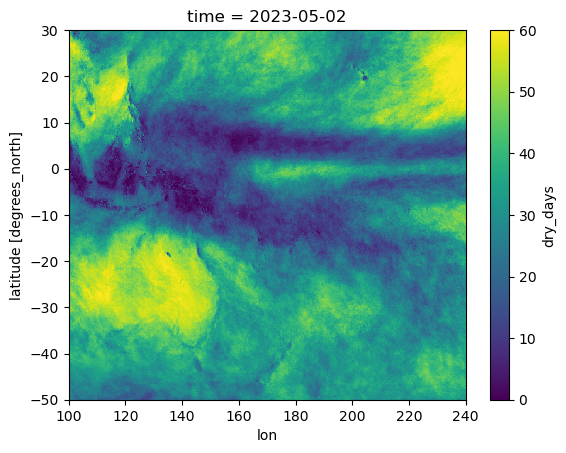

In [24]:
dset_ndays["dry_days"].plot()

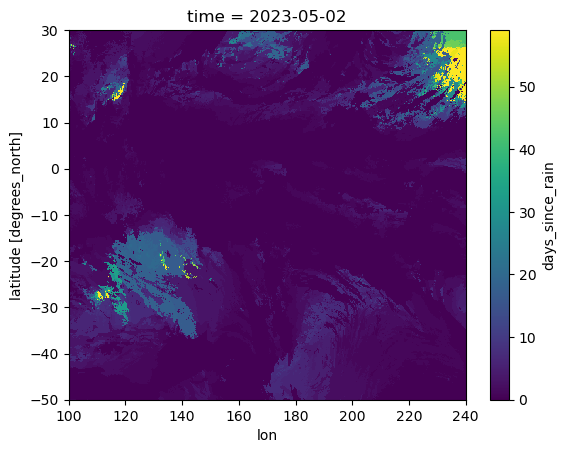

In [25]:
dset_ndays["days_since_rain"].plot()

In [26]:
lfiles_clim = list(dpath_climatology.glob(f"*DOY_{DOY:03d}*.nc"))

In [27]:
len(lfiles_clim)

3

In [28]:
lfiles_clim

[PosixPath('/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge/SP/climatologies/60days/1991_2020/netcdf/MSWEP_Daily_nogauge_DOY_122_60days_runsum_average.nc'),
 PosixPath('/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge/SP/climatologies/60days/1991_2020/netcdf/MSWEP_Daily_nogauge_DOY_122_60days_runsum_quantiles.nc'),
 PosixPath('/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge/SP/climatologies/60days/1991_2020/netcdf/MSWEP_Daily_nogauge_DOY_122_60days_runsum_SPI_params.nc')]

In [29]:
climatological_average = xr.open_dataset(
    dpath_climatology.joinpath(
        f"MSWEP_Daily_nogauge_DOY_{DOY:03d}_{nbdays_agg}days_runsum_average.nc"
    )
)

In [30]:
int(climatological_average["DOY"].data) == DOY

True

In [31]:
climatological_quantiles = xr.open_dataset(
    dpath_climatology.joinpath(
        f"MSWEP_Daily_nogauge_DOY_{DOY:03d}_{nbdays_agg}days_runsum_quantiles.nc"
    )
)

In [32]:
int(climatological_quantiles["DOY"].data) == DOY

True

In [33]:
climatological_SPI_params = xr.open_dataset(
    dpath_climatology.joinpath(
        f"MSWEP_Daily_nogauge_DOY_{DOY:03d}_{nbdays_agg}days_runsum_SPI_params.nc"
    )
)

In [34]:
int(climatological_SPI_params["DOY"].data) == DOY

True

In [35]:
climatological_average = climatological_average.squeeze()

In [36]:
climatological_quantiles = climatological_quantiles.squeeze()

In [37]:
climatological_SPI_params = climatological_SPI_params.squeeze()

In [38]:
climatological_average = climatological_average.rename({varname: f"{varname}_average"})

In [39]:
climatological_quantiles = climatological_quantiles.rename(
    {varname: f"{varname}_quantiles"}
)

In [40]:
dset_accum["anoms"] = dset_accum[varname] - climatological_average[f"{varname}_average"]

In [41]:
dset_accum

<xarray.Dataset>
Dimensions:        (time: 1, lat: 800, lon: 1400)
Coordinates:
  * time           (time) datetime64[ns] 2023-05-02
  * lon            (lon) float32 100.1 100.2 100.3 100.4 ... 239.8 239.9 240.0
  * lat            (lat) float32 -49.95 -49.85 -49.75 ... 29.75 29.85 29.95
    DOY            int64 122
Data variables:
    precipitation  (time, lat, lon) float32 159.1 162.1 162.7 ... 20.77 21.38
    anoms          (time, lat, lon) float32 -50.6 -47.75 -47.25 ... 2.739 2.47
Attributes:
    history:          Created on 2023-03-05 01:02
    input_data_hash:  8ab2da0395b0d92c9629341f6ff44b00769d023bae70fe684dfb22b...
    filename_origin:  2023063.nc
    ndays:            60
    last_day:         2023-05-02
    DOY:              122

In [42]:
dset = geo.make_mask_from_gpd(dset, EEZs, subset=False, insert=True, mask_name="EEZs")

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/pygeos/io.py:511: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [43]:
dset = xr.merge(
    (
        dset_accum,
        climatological_average,
        climatological_quantiles,
        climatological_SPI_params,
        dset_ndays
    )
)

In [44]:
dset.nbytes / 1e9

0.183688936

In [45]:
dset.to_netcdf(
    opath.joinpath(f"MSWEP_dset_merged_{nbdays_agg}days_to_{last_date:%Y-%m-%d}.nc")
)

In [46]:
opath

PosixPath('/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge/SP/outputs')

In [47]:
!ls /media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge/SP/outputs

MSWEP_dset_merged_30days_to_2023-05-02.nc
MSWEP_dset_merged_60days_to_2023-05-02.nc
MSWEP_dset_merged_90days_to_2023-05-02.nc
